In [87]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import exp, pi
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
from tqdm.notebook import tqdm as tqdm_notebook

In [88]:
#размер области + размер волнового пакета
l = 1
l1 = l/50

#параметры проводимости (sigma) для PML
a = 100
delta = l1 * 5

#параметры сетки по времени и пространству
Nz = 400
T = 1.2
Nt = 450
zE = np.linspace(-l, l, Nz)
h = zE[1] - zE[0]
zH = np.linspace(-l + h/2, l + h/2, Nz)
tau = T/Nt
r = tau/h
print("Число Куранта:", r)

Число Куранта: 0.532


In [89]:
# проводимость для PML
def sigma(z):
    if(-l < z < -l + delta):
        return a * ((z + l - delta)/delta)**2
    elif(l - delta < z < l):
        return a * ((z - l + delta)/delta)**2
    else:
        return 0

# начальный волновой пакет    
def f(z):
    return exp(-z**2/2/l1**2)
# его производная для Н
def fd(z):
    return -z/l1**2 * exp(-z**2/2/l1**2)

def initialize():
    E = np.array([f(z) for z in zE])
    H = tau/2 * np.array([fd(z) for z in zH])
    Em = E.copy()
    Hm = H.copy()
    E0 = np.array([f(z) for z in zE])
    E1 = np.zeros(Nz)
    for j in range(1, Nz - 1):
        E1[j] = E0[j] + r**2/2 * (E0[j+1] - 2*E0[j] + E0[j-1])
    return E, H, E0, E1, Em, Hm

sigmaE = np.array([sigma(z) for z in zE])
sigmaH = np.array([sigma(z) for z in zH])

def new_layer_maxwell_eq_PML(E, H):
    E_cur = np.zeros(Nz)
    H_cur = np.zeros(Nz)
    for j in range(1, Nz - 1):
        E_cur[j] = (E[j] * (1 - 2*pi*sigmaE[j] * tau) + r * (H[j] - H[j - 1]))/(1 + 2*pi*sigmaE[j] * tau)
    for j in range(Nz - 1):    
        H_cur[j] = ((1 - 2*pi*sigmaH[j] * tau) * H[j] + r * (E_cur[j+1] - E_cur[j])) / (1 + 2*pi*sigmaH[j] * tau)
    return E_cur, H_cur

def new_layer_wave_eq(E0, E1):
    E_cur = np.zeros(Nz)
    for j in range(1, Nz - 1):
        E_cur[j] = 2 * E1[j] - E0[j] + r**2 * (E1[j + 1] - 2 * E1[j] + E1[j - 1])
    return E_cur, E1

def new_layer_maxwell_eq(E, H):
    E_cur = np.zeros(Nz)
    H_cur = np.zeros(Nz)
    for j in range(1, Nz - 1):
        E_cur[j] = (E[j]  + r * (H[j] - H[j - 1]))
    for j in range(Nz - 1):    
        H_cur[j] = ( H[j] + r * (E_cur[j+1] - E_cur[j]))
    
    return E_cur, H_cur

In [90]:
E, H, E0, E1, Em, Hm = initialize()
errors_weq = np.zeros(Nt)
errors_meq = np.zeros(Nt)
fig, ax = plt.subplots(figsize = (12, 7))
ax.grid(True)
ln1, = plt.plot([], [], color = 'b', linestyle = '-', label = "E numerical from Maxwell + PML")
ln2, = plt.plot([], [], color = 'c', linestyle = ':', label = "H numerical from Maxwell + PML")
ln3, = plt.plot([], [], color = 'r', linestyle = '-', label = "E precise")
ln4, = plt.plot([], [], color = 'g', linestyle = '-', label = "E numerical from wave equation")
ln5, = plt.plot([], [], color = 'm', linestyle = '-', label = "E numerical from Maxwell")
ln6, = plt.plot([], [], color = 'y', linestyle = ':', label = "H numerical from Maxwell")

ln1.set_data(zE, E)
ln2.set_data(zH, H)
ln3.set_data(zE, E)
ln4.set_data(zE, E)
ln5.set_data(zE, Em)
ln6.set_data(zH, Hm)

def precise_solution(nt):
    E_pr = np.array([(f(z - nt*tau) + f(z + nt*tau))/2 for z in zE])
    return E_pr

def init():
    ax.set_xlim(-l, l)
    ax.set_ylim(-1, 1)
    ax.legend()
    return ln1,

def update(nt):
    global E, H, E0, E1, Em, Hm
    E, H = new_layer_maxwell_eq_PML(E, H)
    E1, E0 = new_layer_wave_eq(E0, E1) 
    Em, Hm = new_layer_maxwell_eq(Em, Hm)
    E_pr = precise_solution(nt + 1)
    ln1.set_data(zE, E)
    ln2.set_data(zH, H)
    ln3.set_data(zE, E_pr)
    ln4.set_data(zE, E0)
    ln5.set_data(zE, Em)
    ln6.set_data(zH, Hm)    
    errors_weq[nt] = np.max(np.abs(E0 - E_pr))
    errors_meq[nt] = np.max(np.abs(E_pr - E))
    return ln1,

anim = FuncAnimation(fig, update, frames=tqdm_notebook(range(Nt)), init_func = init, interval = 50, blit=True)
html5video = anim.to_html5_video()
plt.close()
HTML(html5video)

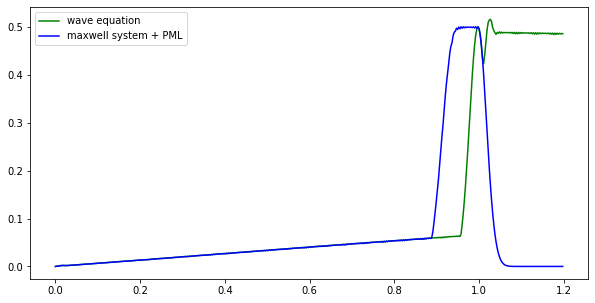

In [91]:
plt.figure(figsize = (10, 5))
plt.plot(np.arange(Nt) * tau, errors_weq, label = "wave equation", color = "g")
plt.plot(np.arange(Nt) * tau, errors_meq, label = "maxwell system + PML", color = "b")
plt.legend()